In [1]:
import kala
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
import seaborn as sns
from tqdm import tqdm

## Prelimaries

In [3]:
def _helper_diagonal_sbm(num_nodes, p_off, p_diag=1.0, seed=0, return_pos=True):
    n = num_nodes // 2
    sizes = [n, n + num_nodes % 2]

    p_mat = [
        [p_diag, p_off],
        [p_off, p_diag],
    ]

    g = nx.stochastic_block_model(sizes, p_mat, seed=seed)
    # g.graph["partition"]

    return g


def _helper_two_group_assigment(num_nodes, thresholds, seed=0):
    rng = np.random.default_rng(seed)

    n = num_nodes // 2
    sizes = [n, n + num_nodes % 2]
    block1 = rng.random(size=n) < thresholds[0]
    block2 = rng.random(size=n + num_nodes % 2) < thresholds[1]

    return np.hstack((block1, block2))


def _get_metrics(game, is_saver=None):
    n = game.get_num_players()
    return (
        game.get_total_wealth() / n,
        game.get_num_savers() / n,
        # game.get_total_wealth(filt=is_saver),
        # game.get_total_wealth(filt=~is_saver),
    )

In [4]:
def helper_init(
    num_players,
    group_thresholds,
    differential_efficient,
    differential_inefficient,
    sigma,
    memory_length,
    update_rule,
    rng=0,
):
    # Initialise strategy
    strategy = kala.CooperationStrategy(
        stochastic=True,
        rng=rng,
        differential_efficient=differential_efficient,
        differential_inefficient=differential_inefficient,
        dist_sigma_func=sigma,
    )

    # Initialise players
    is_saver = _helper_two_group_assigment(num_players, thresholds=group_thresholds)
    players = [
        kala.InvestorAgent(
            is_saver=s,
            update_from_n_last_games=memory_length,
            update_rule=update_rule,
        )
        for s in is_saver
    ]

    # Initialise network
    g = _helper_diagonal_sbm(num_players, p_off=0.1)
    G = kala.SimpleGraph(g, nodes=players)

    # Combine everything and initialise game
    game = kala.DiscreteTwoByTwoGame(G, strategy)

    return game, g, is_saver  # g, is_saver: returned for plotting


def helper_run_simulation(game, num_steps):
    game.reset_agents()

    data = [_get_metrics(game)]

    for _ in range(num_steps):
        game.play_round()
        data.append(_get_metrics(game))

    is_saver_final = [player.get_trait("is_saver") for player in game._players]

    return pd.DataFrame(data, columns=["avg_wealth", "frac_savers"]), is_saver_final


def helper_plot_simulation(df, g, savers_init, savers_final):
    pos = nx.spring_layout(g, seed=0)

    fig, axs = plt.subplots(ncols=3, figsize=(12, 4), width_ratios=(1, 1, 2))

    ax = axs[0]
    nx.draw(g, node_color=savers_init, pos=pos, ax=ax)
    ax.set_title("Init")

    ax = axs[1]
    nx.draw(g, node_color=savers_final, pos=pos, ax=ax)
    ax.set_title("Final")

    ax = axs[2]
    axes = [ax, ax.twinx()]

    for column, color, axis in zip(df.columns, ["C0", "C1"], axes):
        df[column].plot(color=color, ax=axis)
        axis.tick_params(axis="y", labelcolor=color)
        axis.set_ylabel(column, color=color);

In [11]:
# Constants

num_players = 40
group_thresholds = [0.5, 0.5]
num_steps = 300

differential_efficient = 0.5
differential_inefficient = 0.5

sigma = lambda x: 1

memory_length = 5
weights = [5, 0, 3, 20, 1]
fraction = 0.7

update_rule = kala.models.memory_rules.WeightedMemoryRule(weights=weights, fraction=fraction)

game, g, savers_init = helper_init(
                                    num_players,
                                    group_thresholds,
                                    differential_efficient,
                                    differential_inefficient,
                                    sigma,
                                    memory_length,
                                    update_rule,
                                )
df, savers_final = helper_run_simulation(game, num_steps)

In [18]:
def get_time_to_zero(observations):
    times = np.where(observations==0)[0]
    if len(times) != 0:
        min_time = min(times)
    else:
        min_time = -1
    return min_time

In [7]:
# Stationary test

def stationary_test(observations, threshold=0.1, significance=0.01):
    """function to test stationarity of observed data"""
    stable = True

    size = len(observations)
    slope = np.arange(size)

    data_to_test = observations + slope

    values = np.vstack((np.arange(size), np.ones(size))).T
    model = sm.OLS(data_to_test, values).fit()

    observed_slope = model.params[0]
    p_slope = model.summary2().tables[1]['P>|t|']["x1"]

    if (observed_slope < 1 + threshold) and (p_slope < significance):
        return stable
    else:
        return not stable
    
def stationary_test_adf(observations):
    """
    function to test stationarity using an
    augmented Dickey-Fuller test with a 1% significance
    """
    stationarity = True

    if observations.min() != observations.max():
        results = adfuller(observations)

        adf = results[0]
        p_value = results[1]
        critical_value_001 = results[4]["1%"]

        if (adf < critical_value_001) and (p_value < 0.01):
            return stationarity
        else:
            return not stationarity
    else:
        return stationarity
    
def stationary_test_std(observations: pd.DataFrame, window):
    """
    function to test stationarity of the standard deviation using an
    augmented Dickey-Fuller test with a 1% significance
    """
    rolled_std = observations.rolling(window).std().dropna()
    stationarity = stationary_test_adf(rolled_std)

    return stationarity

# phase diagram

When introducing updating rules and memory, the percentage of savers will change over time. We are interested in knowing how different parameters determine the evolution of the system over time

In [30]:
def savers_analysis(
        num_players,
        group_thresholds,
        sigma,
        num_steps,
        memory_length,
        update_rule,
        name_rule,
        len_linspace,
        num_simulations,
        timewindow_stability,
        window,
):
    
    start = 0.01
    end = 0.99
    space = np.linspace(start, end, len_linspace)

    final_savers_arr = np.zeros((num_simulations, len_linspace, len_linspace))
    timeseries_savers_arr_adf = np.zeros((num_simulations, len_linspace, len_linspace))
    timeseries_savers_arr_std = np.zeros((num_simulations, len_linspace, len_linspace))
    stability_arr = np.zeros((len_linspace, len_linspace), dtype=bool)

    for sim in tqdm(np.arange(num_simulations)):
        for (i, differential_efficient) in enumerate(space):
            for (j, differential_inefficient) in enumerate(space):

                # Init
                game, g, savers_init = helper_init(
                    num_players,
                    group_thresholds,
                    differential_efficient,
                    differential_inefficient,
                    sigma,
                    memory_length,
                    update_rule,
                )
                df, savers_final = helper_run_simulation(game, num_steps)

                final_savers_arr[sim, i, j] = df.loc[num_steps, "frac_savers"]
                timeseries_savers_arr_adf[sim, i, j] = stationary_test_adf(df.loc[:, "frac_savers"].values[-timewindow_stability:])
                timeseries_savers_arr_std[sim, i, j] = stationary_test_std(df.loc[-timewindow_stability:, "frac_savers"], window)


    #for i in np.arange(len_linspace):
    #    for j in np.arange(len_linspace):
    #        stable = stationary_test_adf(timeseries)
    ##        timeseries = timeseries_savers_arr[:, i, j, :].mean(axis=0)
    #        stability_arr[i, j] = stable
    final = final_savers_arr.mean(axis=0)
    stability_arr_adf = timeseries_savers_arr_adf.mean(axis=0)
    stability_arr_std = timeseries_savers_arr_std.mean(axis=0)

    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    ticks = np.round(space, 2)

    sns.heatmap(final, vmin=0, vmax=1., ax=ax[0], xticklabels=ticks, yticklabels=ticks)
    ax[0].set_title("Rule")
    ax[0].set_xlabel("differential_efficient")
    ax[0].set_ylabel("differential_inefficient")

    sns.heatmap(stability_arr_adf, vmin=0, vmax=1., ax=ax[1], xticklabels=ticks, yticklabels=ticks)
    ax[1].set_title("Stability")
    ax[1].set_xlabel("differential_efficient")
    ax[1].set_ylabel("differential_inefficient")

    sns.heatmap(stability_arr_std, vmin=0, vmax=1., ax=ax[2], xticklabels=ticks, yticklabels=ticks)
    ax[2].set_title("S.D. Stability")
    ax[2].set_xlabel("differential_efficient")
    ax[2].set_ylabel("differential_inefficient")

In [31]:
# Constants

num_players = 40
group_thresholds = [0.5, 0.5]
num_steps = 300

sigma = lambda x: 1

Phase diagram for differential_efficient and differential_inefficient

  0%|          | 0/5 [00:00<?, ?it/s]/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWa

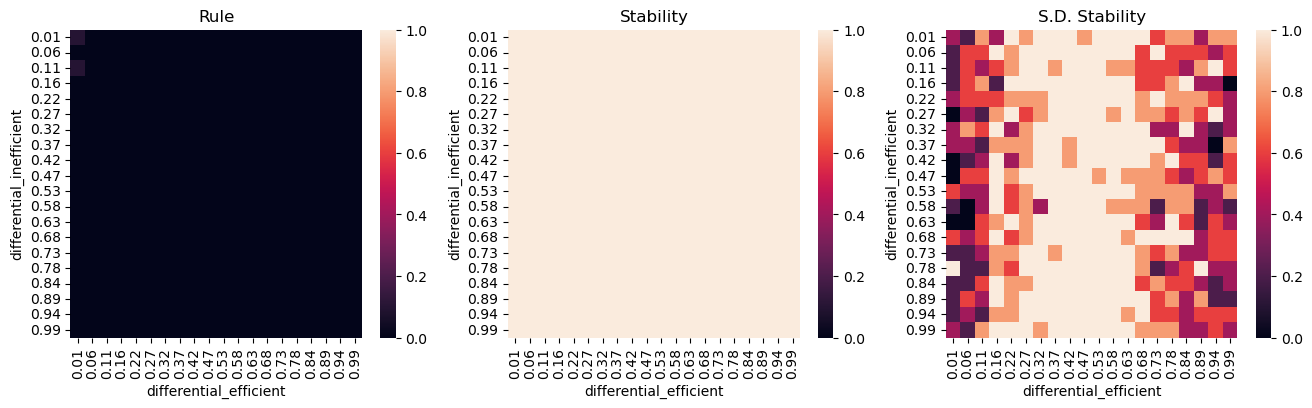

In [32]:
# Agent parameters
memory_length = 10
update_rule = kala.models.memory_rules.AverageMemoryRule()
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()
name_rule = "Average memory"

num_simulations = 5
timewindow_stability = int(np.floor(num_steps/2))
len_linspace = 20


savers_analysis(num_players, group_thresholds, sigma, num_steps,
                memory_length, update_rule, name_rule,
                len_linspace, num_simulations, timewindow_stability, 10)

100%|██████████| 5/5 [21:50<00:00, 262.04s/it]


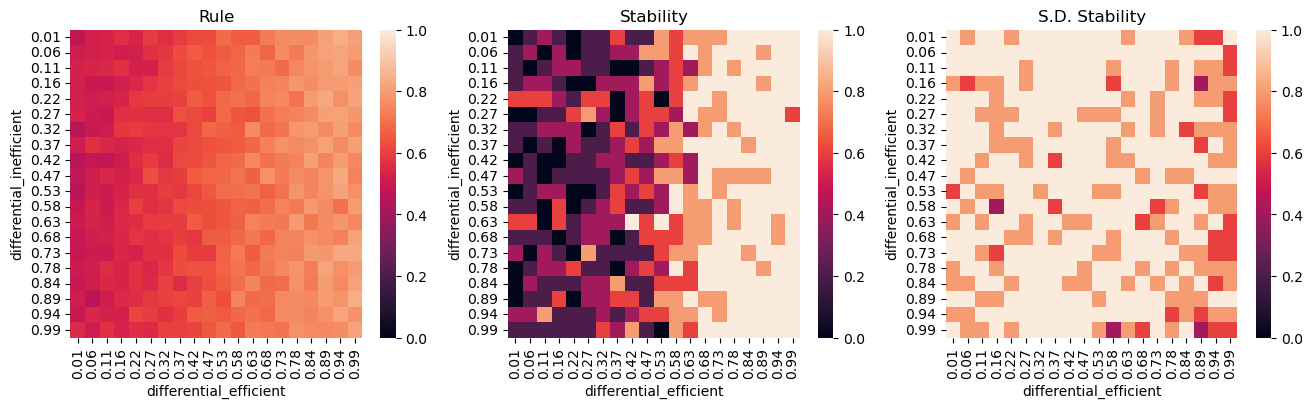

In [33]:
# Agent parameters
memory_length = 10
update_rule = kala.models.memory_rules.AllPastMemoryRule()
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()
name_rule = "All past memory"

num_simulations = 5
timewindow_stability = int(np.floor(num_steps/2))
len_linspace = 20

savers_analysis(num_players, group_thresholds, sigma, num_steps,
                memory_length, update_rule, name_rule,
                len_linspace, num_simulations, timewindow_stability, 10)


100%|██████████| 5/5 [21:24<00:00, 256.87s/it]


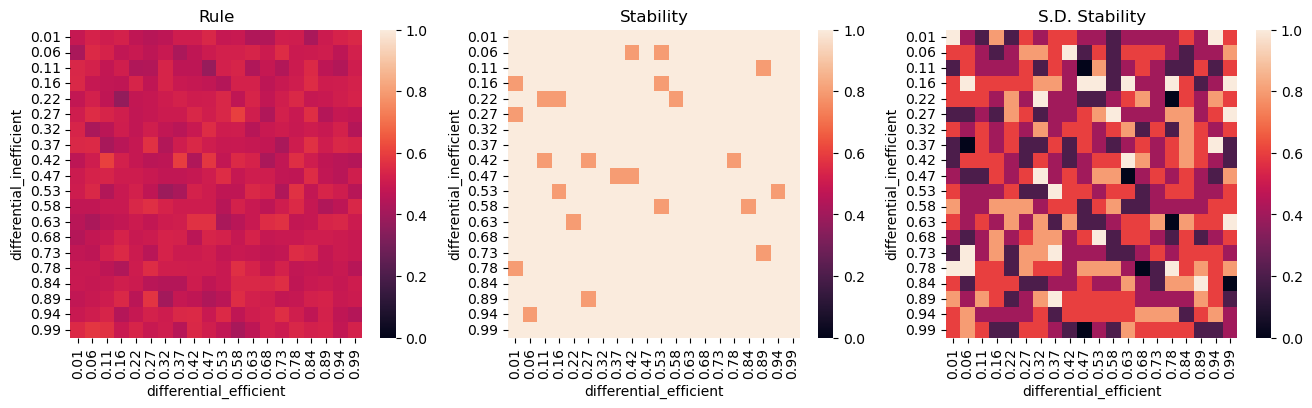

In [34]:
# Agent parameters
memory_length = 10
update_rule = kala.models.memory_rules.AnyPastMemoryRule()
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()
name_rule = "Any past memory"

num_simulations = 5
timewindow_stability = int(np.floor(num_steps/2))
len_linspace = 20

savers_analysis(num_players, group_thresholds, sigma, num_steps,
                memory_length, update_rule, name_rule,
                len_linspace, num_simulations, timewindow_stability, 10)

  0%|          | 0/5 [00:00<?, ?it/s]/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWa

Text(1046.0163398692812, 0.5, 'differential_inefficient')

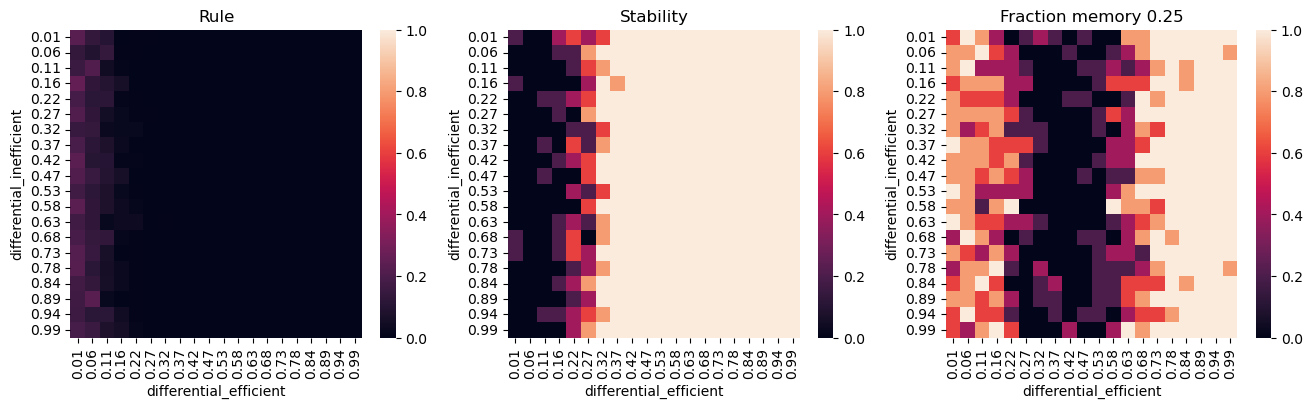

In [35]:
# Agent parameters
memory_length = 10
fraction = 0.25
update_rule = kala.models.memory_rules.FractionMemoryRule(fraction=fraction)
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()
name_rule = f"Fraction {fraction}"

num_simulations = 5
timewindow_stability = int(np.floor(num_steps/2))
len_linspace = 20

savers_analysis(num_players, group_thresholds, sigma, num_steps,
                memory_length, update_rule, name_rule,
                len_linspace, num_simulations, timewindow_stability,10,)
plt.title(f"Fraction memory {fraction}")
plt.xlabel("differential_efficient")
plt.ylabel("differential_inefficient")

  0%|          | 0/10 [00:00<?, ?it/s]/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/miniconda3/envs/ILO/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeW

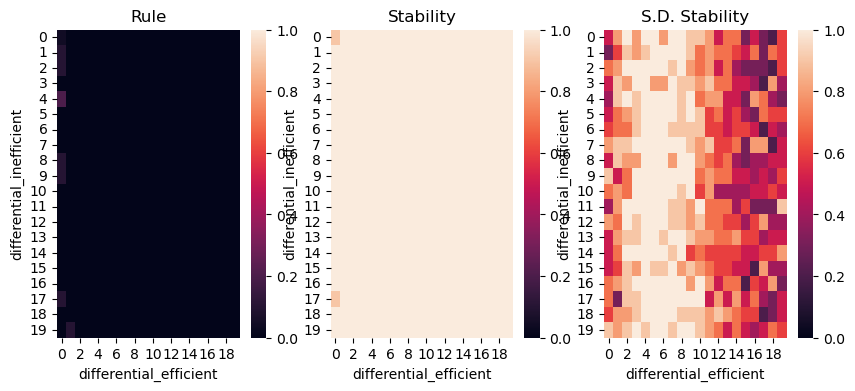

In [14]:
# Agent parameters
memory_length = 10
fraction = 0.75
update_rule = kala.models.memory_rules.FractionMemoryRule(fraction=fraction)
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()
name_rule = f"Fraction {fraction}"

num_simulations = 5
timewindow_stability = int(np.floor(num_steps/2))
len_linspace = 20

savers_analysis(num_players, group_thresholds, sigma, num_steps,
                memory_length, update_rule, name_rule,
                len_linspace, num_simulations, timewindow_stability, 10)